# Computing haplotype statistic and linkage disequilibrium #

## Importing necessary modules for the analyzes ######

In [1]:
from collections import Counter
from functools import lru_cache
import numpy as np
import pandas as pd
import h5py
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
import allel
from dask.diagnostics.progress import ProgressBar
import malariagen_data
import petl as ptl
#ld r**2
import scipy
from scipy.spatial.distance import pdist, squareform

In [2]:
# Print style 
from colorama import Fore, Back, Style
print(Fore.MAGENTA + 'To test the printing style')
print(Style.RESET_ALL) #to reset the printing style

To test the printing style



In [3]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
rcParams = plt.rcParams
base_font_size = 7
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = base_font_size
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
rcParams['savefig.jpeg_quality'] = 100
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000
rcParams['figure.dpi'] = 120
rcParams['figure.facecolor'] = 'w'

/tmp/ipykernel_4796/1673092961.py:25: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  rcParams['savefig.jpeg_quality'] = 100


## Importing malariagen data set
Importing malariagen data set   
Selecting and defining the samples metadata   
Acces to the haplotypes, phased samples    
Let's define the genome region where to locate the SNP, # The AGAP000080 gene is located in the X chromosomes in the region ranging from 1283016 to 1373662 

In [4]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

## Selecting and defining the samples metadata
## Selecting and defining the samples metadata
sets = ['AG1000G-AO', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CD', 
        'AG1000G-CF','AG1000G-CI', 'AG1000G-CM-A', 'AG1000G-CM-B', 'AG1000G-CM-C', 
        'AG1000G-FR', 'AG1000G-GA-A', 'AG1000G-GH', 'AG1000G-GM-A', 'AG1000G-GM-B', 
        'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-GW', 
        'AG1000G-KE', 'AG1000G-ML-A', 'AG1000G-ML-B', 'AG1000G-MW', 'AG1000G-MZ', 
        'AG1000G-TZ', 'AG1000G-UG']
df_samples = ag3.sample_metadata(sample_sets=sets)

## Acces to the haplotypes 
df_hap = ag3.haplotypes(region="X", analysis='gamb_colu_arab', sample_sets=sets)

# samples phase 
samples_phased = df_hap['sample_id'].values
df_samples_phased = df_samples.set_index("sample_id").loc[samples_phased].reset_index()
#df_samples_phased

# Let's define the genome region where to locate the SNP
# The AGAP000080 gene is located in the X chromosomes in the region ranging from 1283016 to 1373662
hap_variant = df_hap['variant_position'].data
hap_pos = allel.SortedIndex(hap_variant)

#######
loc_region = hap_pos.locate_range(1283016,1373662)
#loc_region
pos_loc = hap_pos[loc_region]

## Cohort 
#cohort = "species == 'coluzzii' or species == 'gambiae'"
#loc_samples = df_samples_phased.query(cohort).index.values
Fru_haps = df_hap.sel(variants = loc_region)

In [5]:
with ProgressBar():
    print(Fore.MAGENTA + 'Processing...', Style.RESET_ALL)
    gt_cohort = allel.GenotypeDaskArray(Fru_haps['call_genotype'].data)
    gt_cohort_arr = allel.GenotypeArray(gt_cohort)
    ht_cohort = allel.HaplotypeArray(gt_cohort.to_haplotypes())
    print('...')
    print(Fore.MAGENTA + f'Number of haplotypes = {ht_cohort.n_haplotypes}.')
    print(Fore.MAGENTA + f'Haplotype diversity = {allel.haplotype_diversity(ht_cohort)}.')
    print(Fore.MAGENTA + 'done...', Style.RESET_ALL)

Processing... 
[########################################] | 100% Completed | 13.3s
[########################################] | 100% Completed | 15.6s
...
Number of haplotypes = 5548.
Haplotype diversity = 0.9999591223404014.
done... 


### Let's select multiple sample cohort within the data set and compute haplotype statistic 
Define population cohort, species cohort   
Compute haplotype by cohort  
Compute haplotype statistic   
Warping haplotype statistic to make dataFrame 

In [6]:
## Let's select multiple sample query within the data set
## define pop 
pop_cohort = dict([(f"{c} (An. {s})", list(df.index)) for (c, s), df in df_samples_phased.groupby(['country_ISO', 'aim_species'])])
sp_cohort = dict([(f"An. {s}", list(df.index)) for (s), df in df_samples_phased.groupby(['aim_species'])])

# Haplotype dict 
haplo_dict, genotyp= {}, {}
for key in pop_cohort.keys():
    genotyp[key] = gt_cohort_arr.take(pop_cohort[key], axis=1)
    haplo_dict[key] = allel.HaplotypeArray(genotyp[key].to_haplotypes())
    #ihs_dict[key] = allel.ihs(haplo_dict[key][loc], pos = pos_loc, gap_scale=100, max_gap=1000)

#Haplotypes statistics 
Hap_div, H1, H12, H123, H1_2 = {}, {}, {}, {}, {}
for key in pop_cohort.keys():
    Hap_div[key] = allel.moving_haplotype_diversity(haplo_dict[key], size=500, step=100)
    H1[key], H12[key], H123[key], H1_2[key] = allel.moving_garud_h(haplo_dict[key], size=500, step=100)
print('done...')

done...


In [7]:
## Warping to make dataFrame
frame1, frame2, frame3, frame4, frame5, country_id = [], [], [], [], [], []
for key in pop_cohort.keys():
    if key.split(' (')[1] in ['An. coluzzii)', 'An. gambiae)', 'An. arabiensis)']:
        for n in range(len(Hap_div[key])):
            frame1.append(Hap_div[key][n])
            frame2.append(H1[key][n])
            frame3.append(H12[key][n])
            frame4.append(H123[key][n])
            frame5.append(H1_2[key][n])
            country_id.append(key)
Hap_stat = pd.DataFrame(list(zip(country_id, frame1)), columns =['country', 'H'])
H1_tab = pd.DataFrame(list(zip(country_id, frame2)), columns =['country', 'H1'])
H12_tab = pd.DataFrame(list(zip(country_id, frame3)), columns =['country', 'H12'])
H123_tab = pd.DataFrame(list(zip(country_id, frame4)), columns =['country', 'H123'])
H1_2_tab = pd.DataFrame(list(zip(country_id, frame5)), columns =['country', 'H1_2'])

Hap_stat.insert(2, 'H1', list(H1_tab.H1))
Hap_stat.insert(3, 'H12', list(H12_tab.H12))
Hap_stat.insert(4, 'H123', list(H123_tab.H123))
Hap_stat.insert(5, 'H1_2', list(H1_2_tab.H1_2))

Hap_stat.to_csv('R/Hap_stat.csv') ## to be used in R for plotting
Hap_stat 

#del frame1, frame2, frame3, frame4, frame5, country_id, H1_tab, H12_tab, H123_tab, H1_2_tab, Hap_div, H1, H12, H123, H1_2
print('done...')

done...


## computing Linkage desequilibrium ####
Import the Non-synonymous snp with max_al_freq > 0.05    
Look for the same SNP position in the Haplotypes data   
Selecting Haplotype    
Calculate ld cor (r)    
Defining function to plot allelic frequency, to calculate D' and ld, to plot ld       
Calculating ld   

In [8]:
## Import the Non-synonymous snp with max_al_freq > 0.05 
snp_drop = pd.read_csv('R/Non_synonymous_snp_filt.csv')  
snp_drop.rename({'Unnamed: 0': 'idx'}, axis=1, inplace=True)
#snp_drop.head()

## Look for the same SNP position in the Haplotypes data
pos_indf = []
for i in allel.SortedIndex(sorted(snp_drop.position)):
    if i in pos_loc:
        pos_indf.append(i)
# Subseting the df 
snp_drop = snp_drop[snp_drop['position'].isin(pos_indf)]
snpdrop_ptl = ptl.fromdataframe(snp_drop)
dt = allel.SortedIndex(sorted(snp_drop.position))
pos_dt = pos_loc.locate_keys(dt)
#del pos_loc, pos_indf, dt
print(np.count_nonzero(pos_dt))
print('done...')

18
done...


In [9]:
## Haplotype selected 
hap_select = ht_cohort[pos_dt]
#hap_select
hgt = allel.GenotypeArray(gt_cohort)
hgt = hgt[pos_dt].to_n_alt(fill=-1)
print('done...')

done...


In [10]:
# Calculate ld cor (r)
r = allel.rogers_huff_r(hgt)
m = squareform(r**2)

# defining colors 
col = plt.cm.get_cmap('PuBu', 128)
col2 = sns.light_palette('darkblue', n_colors=30)
print('done...')

done...


In [11]:
# function to plot allelic frequency
def plot_allele_af(ax=None, **kwargs):
    n = len(snp_drop.max_af)
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2))
    left = np.arange(n) + 0.2
    ax.bar(left, snp_drop.max_af, align='edge', width=0.4, **kwargs)
    ax.set_ylabel('Allele frequency')
    ax.set_xlim(0, n)
    ax.set_xticks([])
    #ax.set_yticks()
    ax.set_xticklabels([])

#plot_allele_af()

In [12]:
## function to calculate D' and ld
def lewontin_d_prime(h, i, j, a=1, b=1):
    """Compute LD between a pair of alleles.
    
    Parameters
    ----------
    h : array
        Haplotype array.
    i : int
        First variant index.
    j : int
        Second variant index.
    a : int
        First variant allele.
    b : int
        Second variant allele.
    
    Returns
    -------
    ld : float
    
    """
    
    # setup
    h = allel.HaplotypeArray(h)
    n_a = n_b = 0  # allele counts
    n_ab = 0  # haplotype counts
    n = 0  # allele number (i.e., number of calls)
    
    # iterate over haplotypes, counting alleles and haplotypes
    for k in range(h.n_haplotypes):
        
        # access alleles
        allele_ik = h[i, k]
        allele_jk = h[j, k]
        
        # only count if allele non-missing at both sites
        if allele_ik < 0 or allele_jk < 0:
            continue
            
        # accumulate
        if allele_ik == a:
            n_a += 1
        if allele_jk == b:
            n_b += 1
        if allele_ik == a and allele_jk == b:
            n_ab += 1
        n += 1
          
    # bail out if no data or either allele is absent or fixed
    if n == 0 or n_a == 0 or n_b == 0 or n == n_a or n == n_b:
        return None
    
    # compute coefficient of linkage disequilibrium * n**2
    D_ab = (n * n_ab) - (n_a * n_b)
    
    # compute normalisation coefficient * n**2
    if D_ab >= 0:
        D_max = min(n_a * (n - n_b), (n - n_a) * n_b)
    else:
        D_max = min(n_a * n_b, (n - n_a) * (n - n_b))

    # compute D prime
    D_prime = D_ab / D_max
    
    return D_prime


def lewontin_d_prime_varloop(h):
    n = len(h)
    ld = np.zeros((n, n), dtype='f8')
    for i,_ in enumerate(h):
        for j,_ in enumerate(h):
            if i != j:
                ld[i, j] = lewontin_d_prime(h=h,i=i,j=j)
    return(ld)

### Calculating ld

In [13]:
# Calculating ld
ld_lewdp = lewontin_d_prime_varloop(hap_select)     

# setting plot ax labels
label_ld = ['%s:%s>%s %s' % (rec.position, rec.ref_allele, rec.alt_allele, rec['aa_change'].rjust(6))
          for rec in snpdrop_ptl.records()]
print('done...')

done...


### Plotting ld

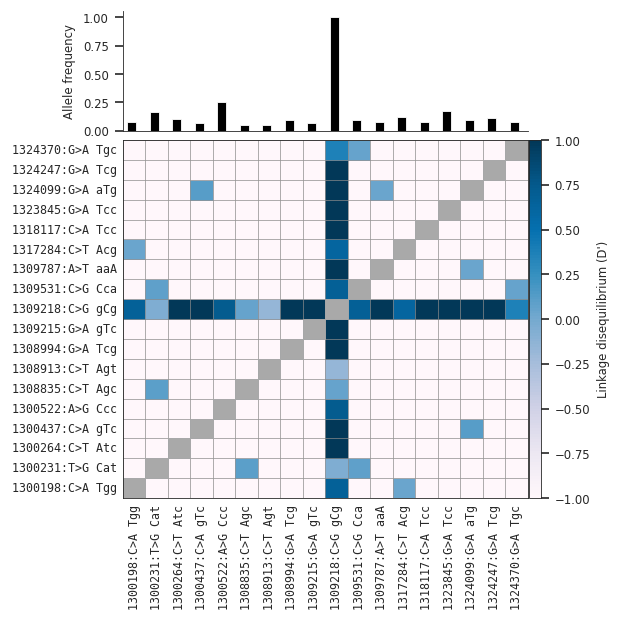

In [14]:
def plot_ld():

    fig = plt.figure(figsize=(5, 5), dpi=120)

    gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[2, 6], width_ratios=[7, .2])
    
    ax = fig.add_subplot(gs[0, 0])
    sns.despine(ax=ax)
    plot_allele_af(ax, color='k')
    
    ax = fig.add_subplot(gs[1, 0])
    im = ax.pcolormesh(ld_lewdp, vmin=-1, vmax=1, cmap=col, shading='flat', edgecolors='gray', 
                       linewidths=.3, antialiased=True)

    labels = ['%s:%s>%s%s' % (rec.position, rec.ref_allele, rec.alt_allele, rec['alt_codon'].rjust(4))
          for rec in snpdrop_ptl.records()]
    # ax.invert_yaxis()
    ticks = np.arange(ld_lewdp.shape[0]) + .5
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels, rotation=90, ha='center', va='top', fontdict=dict(family='monospace'))
    ax.set_yticklabels(labels, rotation=0, va='center', ha='right', fontdict=dict(family='monospace'));
    ax.set_xlim(0, ld_lewdp.shape[0])
    ax.set_ylim(0, ld_lewdp.shape[0])
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    for i in range(ld_lewdp.shape[0] + 1):
        ax.add_patch(plt.Rectangle((i-1, i-1), 1, 1, color='darkgray'))

    cax = fig.add_subplot(gs[1, 1])
    fig.colorbar(im, cax=cax)
#    cax.set_title("Linkage disequilibrium (D')", loc='left')
    cax.set_ylabel("Linkage disequilibrium (D')", va='top')

    fig.tight_layout(pad=0.1)
    fig.savefig('Graph/plot_ld', dpi=300, bbox_inches='tight')

plot_ld()